In [2]:
# 导入相关包
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
%matplotlib inline


In [3]:
# 加载模型
model = tf.keras.models.load_model('data/face_mask_model/')

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

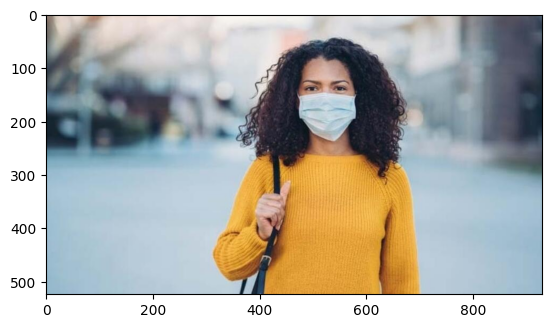

In [6]:
# 挑选测试图片
img = cv2.imread('./test_imgs/women-wearing-mask.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [9]:
# 加载SSD模型
face_detector = cv2.dnn.readNetFromCaffe('./weights/deploy.prototxt.txt','./weights/res10_300x300_ssd_iter_140000.caffemodel')

In [10]:
# 人脸检测得函数
def face_detec(img):
    # 转为Blob
    img_blob = cv2.dnn.blobFromImage(img,1,(300,300),(104,177,123),swapRB=True)
    # 输入
    face_detector.setInput(img_blob)
    # 推理
    detections = face_detector.forward()
    # 遍历结果
    # 获取原图尺寸
    img_h,img_w = img.shape[:2]
    # 人脸数量
    person_count = detections.shape[2]
    for face_index in range(person_count):
        # 置信度
        confidence = detections[0,0,face_index,2]
        # print(confidence)
        if confidence > 0.5:
            locations = detections[0,0,face_index,3:7] * np.array([img_w,img_h,img_w,img_h])
            # print(locations)
            # 取整
            l,t,r,b = locations.astype('int')
            # cv2.rectangle(img,(l,t),(r,b),(0,255,0),5)
            return img[t:b,l:r]
    return None

In [11]:
# 转为blob得函数
def imgBlob(img):
    # 转为Blob
    img_blob = cv2.dnn.blobFromImage(img,1,(100,100),(104,177,123),swapRB=True)
    # 压缩维度
    img_squeeze = np.squeeze(img_blob).T
    # 旋转
    img_rotate = cv2.rotate(img_squeeze,cv2.ROTATE_90_CLOCKWISE)
    # 镜像
    img_flip = cv2.flip(img_rotate,1)
    # 去除负数并归一化
    img_blob = np.maximum(img_flip,0) / img_flip.max()
    
    return img_blob

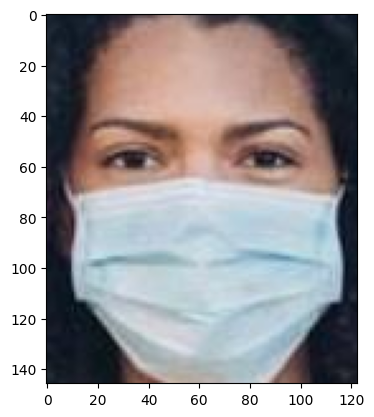

In [15]:
# 裁剪人脸
img_crop = face_detec(img)
plt.imshow(cv2.cvtColor(img_crop,cv2.COLOR_BGR2RGB))

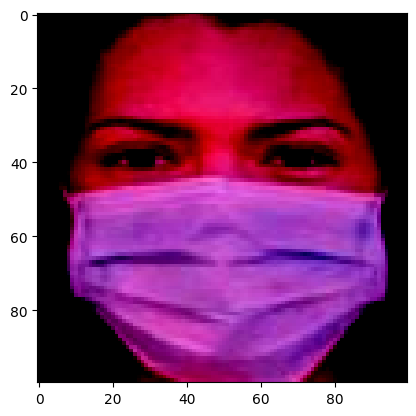

In [17]:
# 转为blob
img_blob = imgBlob(img_crop)
plt.imshow(img_blob)

In [18]:
img_blob.shape


(100, 100, 3)

In [19]:
img_input = img_blob.reshape(1,100,100,3)

In [20]:
img_input.shape

(1, 100, 100, 3)

In [40]:
result = model.predict(img_input)

In [41]:
result[0]

array([9.9999917e-01, 3.8604620e-10, 2.5775762e-08], dtype=float32)

In [42]:
from scipy.special import softmax

In [43]:
result = softmax(result[0])

In [44]:
max_index = result.argmax()

In [45]:
max_value = result[max_index]

In [46]:
import os 

In [47]:
labels = os.listdir('./images/')

In [49]:
labels[max_index]

'1.yes'